# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveshow(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования

In [3]:
signals = {}

### Единичный импульс

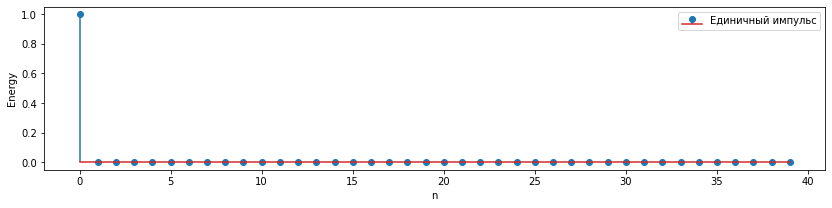

In [4]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

### Единичный скачок

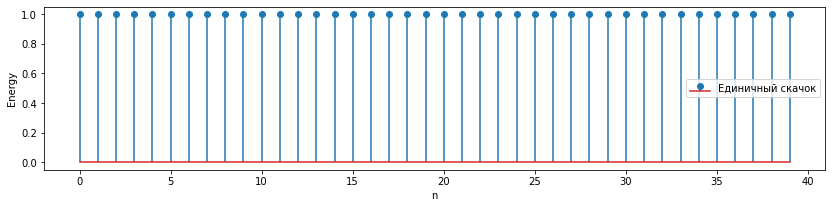

In [5]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

### Синус

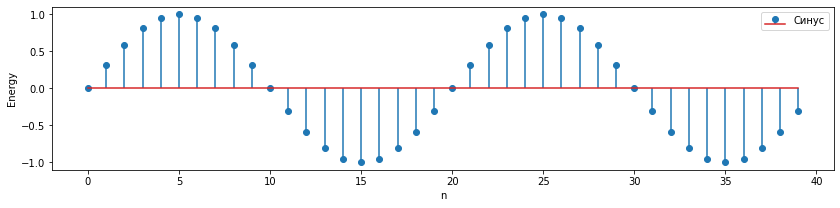

In [6]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

### Шум

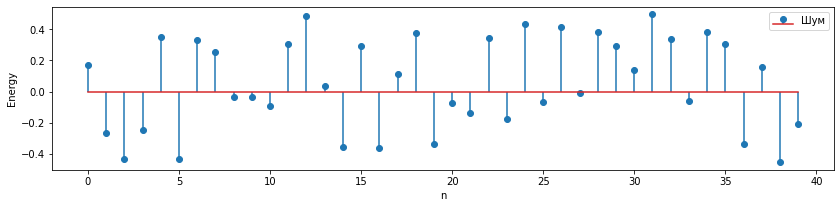

In [7]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT):
$$ X_k = \sum_{n=0}^{N-1} x_{n} \cdot e^{-i \frac{2\pi}{N} k n} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией *scipy.fft.fft*

In [8]:
import math
def DFT(x):
    N = len(x)
    result = np.zeros(N, dtype=complex)
    for k in range(N):
        for n in range(N):
            angle = 2 * np.pi * k * n / N
            result[k] += x[n] * np.exp(-1j * angle)

    return result

Сравнение с библиотекой scipy

In [9]:
def test_DTF(x, transform=DFT):
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

**Подсказка:** учтите, что для БПФ нам нужно, чтобы количество отсчетов сигнала было степенью двойки

In [228]:
def FFT(x):
    # YOUR CODE HERE
    
    #
    raise NotImplementedError()

In [229]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'


NotImplementedError: 

Если вы изменяли длительность исходных сигналов, не забудьте вернуть их изначальную длительность

In [ ]:
# YOUR CODE HERE

# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [10]:
#функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    return np.abs(spec)
   

    raise NotImplementedError()

#функция построения фазового спектра
def get_phi_from_spec(spec):
    return np.angle(spec)
   

    raise NotImplementedError()

In [11]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."

   
print("All OK!")

All OK!


Определим еще одну функцию для отрисовки. Теперь будем рисовать сигнал в частотной области

In [12]:
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
<!-- 1. Почему амплитуда всех гармоник единичного импульса равна единице? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему? -->

### Визуализация:

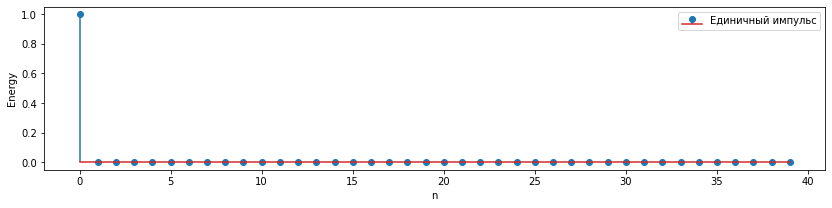

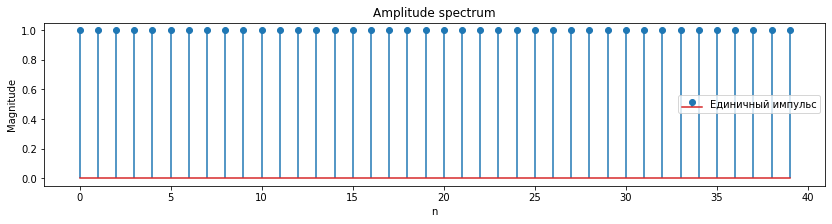

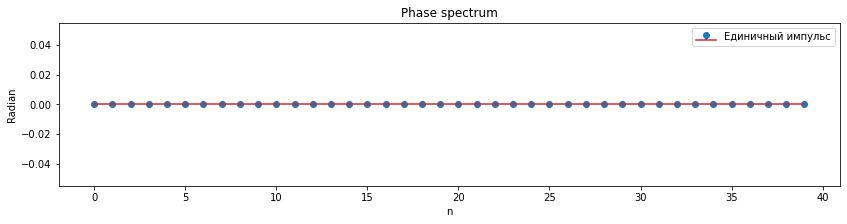

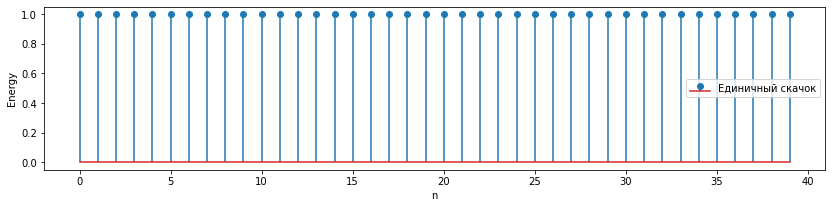

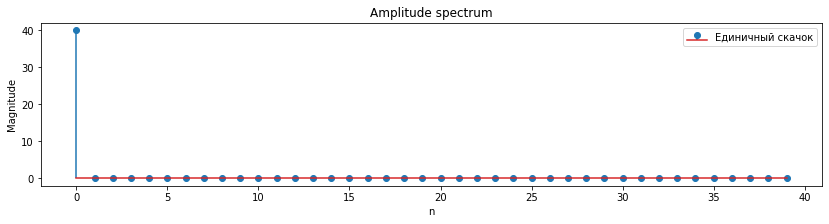

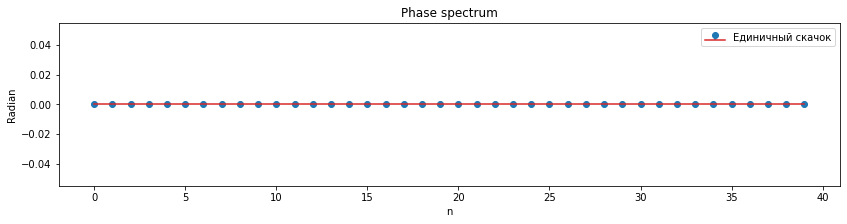

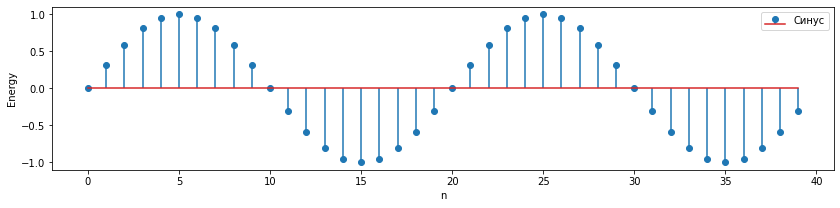

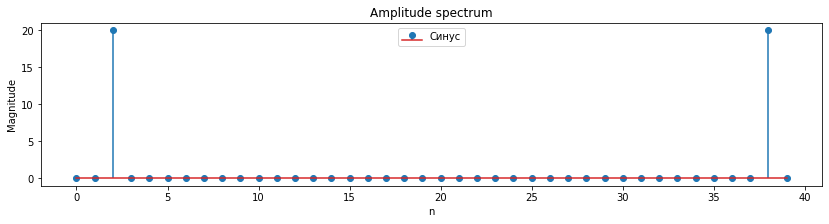

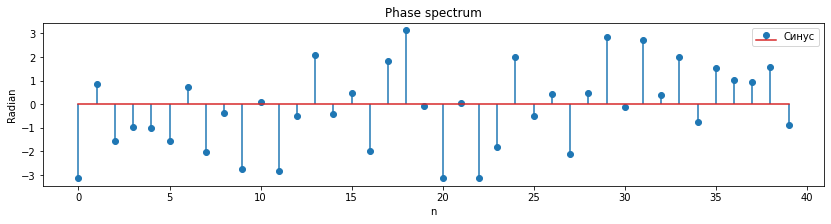

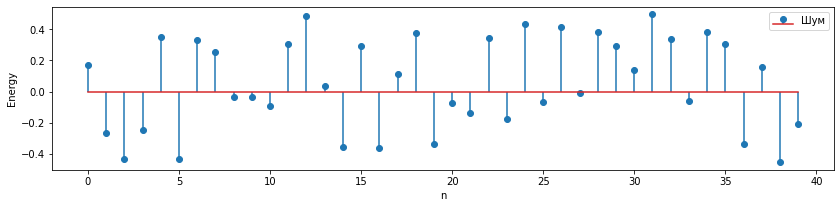

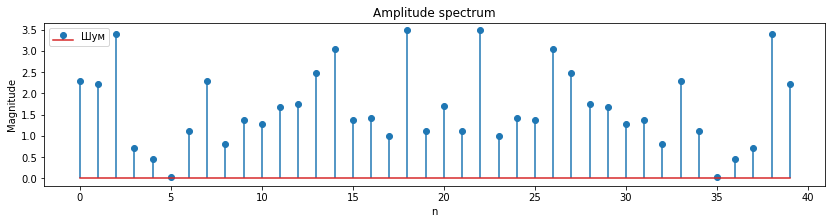

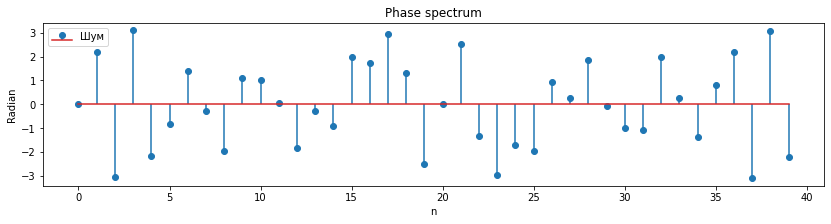

In [13]:
for name, sig in signals.items():
    draw_sig(sig, name=name)
    draw_spec(scipy.fft.fft(sig), name=name)
    for _ in range(10):
        print()

### 1.Почему амплитуда всех гармоник единичного импульса равна константе?

Амплитуда всех гармоник в единичном импульсе равна константе 1. Это происходит из-за специфической природы единичного импульса, который представляет собой сигнал, имеющий амплитуду равную 1 в определенный момент времени и 0 в остальное время. Единичный импульс представляется в виде дельта-функции Дирака (или дельта-импульса), которая имеет следующие свойства:

- Амплитуда в момент времени, где происходит импульс, равна 1 (A = 1): $x_{0} = 1 $
- Амплитуда во всех остальных моментах времени равна 0 (A = 0): $x_{n} = 0 $, кроме $x_{0}$
- Поскольку: $ X_k = \sum_{n=0}^{N-1} x_{n} \cdot e^{-i \frac{2\pi}{N} k n} $, то $X_k = x_{0} \cdot e^{-i \frac{2\pi}{N} k \cdot 0} = x_{0} \cdot e^0 = x_{0} $

### 2. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?

### График амплитудного спектра:

- Частотные компоненты: график амплитудного спектра позволяет идентифицировать присутствие различных частотных компонентов в сигнале. Пики в спектре соответствуют гармоникам сигнала.

- Основная частота: максимальный пик в амплитудном спектре обычно соответствует основной частоте сигнала. Это может быть полезной информацией для определения основной частоты сигнала.

- Гармоники и искажения: пики, отличные от основной частоты, указывают на гармоники и искажения в сигнале. Вы можете определить, насколько чисты гармоники и есть ли искажения.

- Шумы: если амплитудный спектр содержит много высокочастотных компонентов без явных пиков, это может указывать на наличие шумов в сигнале.

### График фазового спектра:

- Фазовые характеристики: фазовый спектр показывает, как фаза меняется с частотой. Это может предоставить информацию о фазовых характеристиках сигнала.

- Сдвиги фазы: фазовый спектр может помочь в определении сдвигов фазы между разными частотами в сигнале. Это важно, например, в радиосвязи и сигналов передачи данных.

- Анализ времени и частоты: фазовый спектр может быть полезным для анализа временных и частотных характеристик сигнала, таких как фазовая модуляция или амплитудная модуляция.

- Обработка сигнала: фазовая информация может быть использована для фильтрации, демодуляции и других операций обработки сигнала.

### 3. Как перевести номер отсчета в частоту?

Для перевода номера отсчета (n) в частоту (f) в дискретном сигнале, можно использовать следующую формулу:

$$f = n * \frac{Fs}{N}$$

Где:

- $f$ - частота в герцах (Гц).
- $n$ - номер отсчета.
- $Fs$ - частота дискретизации в герцах (Гц).
- $N$ - общее число отсчетов в сигнале.

### 4. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

### Полезная информация в фазовом спектре:

- Фазовая модуляция: в некоторых типах сигналов, таких как аудио и видео, фазовый спектр может содержать информацию о модуляции. Например, фазовая модуляция может кодировать музыкальный инструмент, речь или другие характеристики сигнала.

- Синхронизация: фазовый спектр может использоваться для определения времени задержки или сдвига фазы между сигналами, что полезно в радиосвязи, системах передачи данных и обработке изображений.

- Оценка скорости сигнала: фазовый спектр может быть использован для измерения скорости сигнала или движущегося объекта, такого как доплеровский сдвиг в радарных системах.

### Возможные источники шума в фазовом спектре:

- Аддитивный шум: ввод аддитивного шума в сигнал или процессе дискретизации может внести шум в фазовый спектр. Этот шум может маскировать полезную информацию.

- Несущая фаза: в некоторых случаях, фазовый спектр может содержать несущую фазу, которая может быть шумом, особенно если она несет полезную информацию.

- Инструментальные артефакты: некорректно настроенные инструменты, аппаратное оборудование и методы измерения могут внести артефакты и шум в фазовый спектр.

Вообще фазовый спектр не устойчив, а чувстителен к шуму. И вычленение шума становится не простой задачей

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье (Short-time Fourier transform), пользуясь только библиотеками *numpy* и *scipy*. Сравнить с *librosa.stft*


In [23]:
from scipy.signal import get_window
from scipy.fft import fft

def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # x - signal
    # n_fft - fft window size
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    num_samples = len(x)
    num_frames = 1 + (num_samples) // hop_length
    padding=(n_fft // 2, n_fft // 2)
    padded_x = np.pad(x, padding, mode='constant')
    window = get_window(window, n_fft)
    
    spectrogram = np.zeros((n_fft // 2 + 1, num_frames), dtype=np.complex128)

    for i in range(num_frames):
        start = i * hop_length
        end = start + n_fft
        frame = padded_x[start:end]
        windowed_frame = frame * window
        spectrogram[:, i] = fft(windowed_frame, n=n_fft)[:n_fft // 2 + 1]

    return spectrogram

In [24]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    #print(librosa_result)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


Определим функцию для отрисовки

In [25]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Загрузим аудио файл с паровозным гудком

Len is 82175 ( ). Sample rate is 22050


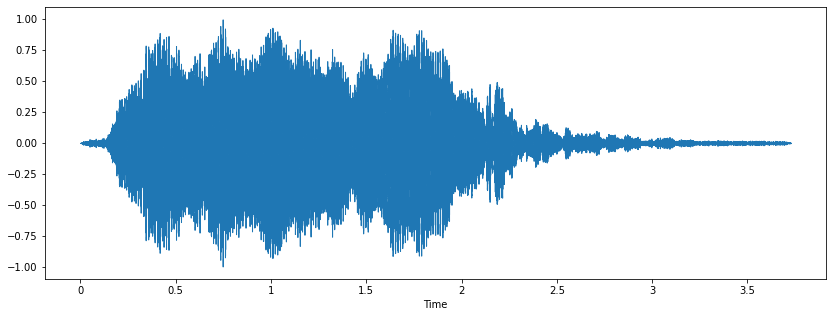

In [26]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr) #в новой версии уже не waveplot, а waveshow

Построим гудок паровоза в частотной области

Гудок паровоза в частотной области


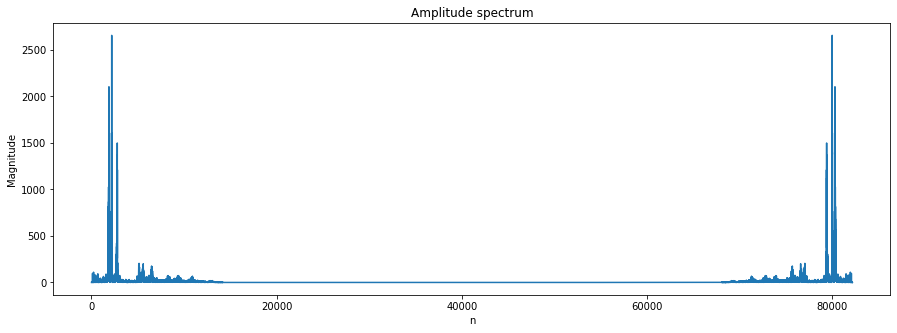

In [27]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


Амплитудный спектр

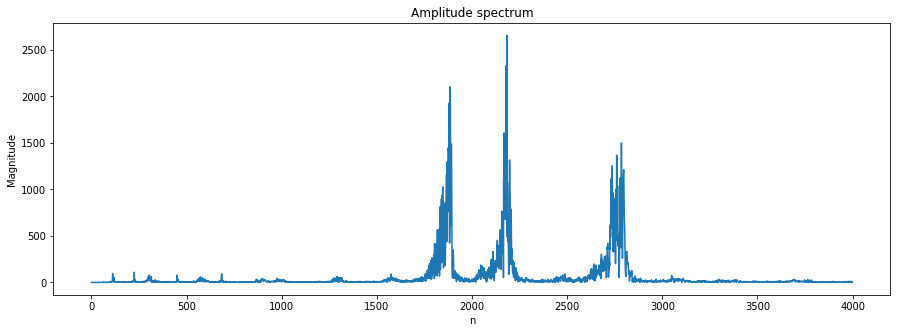

In [28]:

draw_spec(train_whistle_spec[:4000], draw_p=False, figsize=(15,5))


Пики неплохо так видны, построим функцию определения

In [29]:
def harmon_finder(whistle, start, end, tw_sr):
    bigger = 0
    count_add = 0
    for place, digit in enumerate(whistle[start:end]):
        if bigger < digit:
            bigger = digit
            count_add = place
    count = start + count_add
    ### переведем отсчет в частоту - там сверху в ответе есть формула)
    return count * tw_sr/len(whistle)

                                          

### 1 гармоника

In [30]:
first_h = harmon_finder(abs(train_whistle_spec), 1500, 2000,tw_sr)
first_h

505.8016428354122

### 2 гармоника

In [31]:
second_h = harmon_finder(abs(train_whistle_spec), 2000, 2500,tw_sr)
second_h 

585.763918466687

### 3 гармоника

In [32]:
third_h = harmon_finder(abs(train_whistle_spec), 2500, 3000,tw_sr)
third_h

747.2984484332218

### Тест

In [33]:
# task_answer = [ freq1, freq2, freq3 ]
task_answer = [first_h, second_h, third_h]

In [34]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")       

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

In [35]:
def generate_signal(frequencies, amplitudes, duration, sample_rate=44100):
    num_samples = int(duration * sample_rate)
    t = np.linspace(0, duration, num_samples, endpoint=False)
    signal = np.zeros(num_samples)

    for frequency, amplitude in zip(frequencies, amplitudes):
        signal += amplitude * np.sin(2 * np.pi * frequency * t)

    return signal

frequencies = [first_h, second_h, third_h]  # Частоты гармоник
amplitudes = [0.5, 0.5, 0.5]  # Амплитуды гармоник
duration = 5.0  # Продолжительность сигнала в секундах
sample_rate = 44100  # Частота дискретизации

generated_signal = generate_signal(frequencies, amplitudes, duration, sample_rate)


In [36]:
player = ipd.Audio(generated_signal, rate=sample_rate)
ipd.display(player)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Визуализация

Len is 243102. Sample rate is 22050


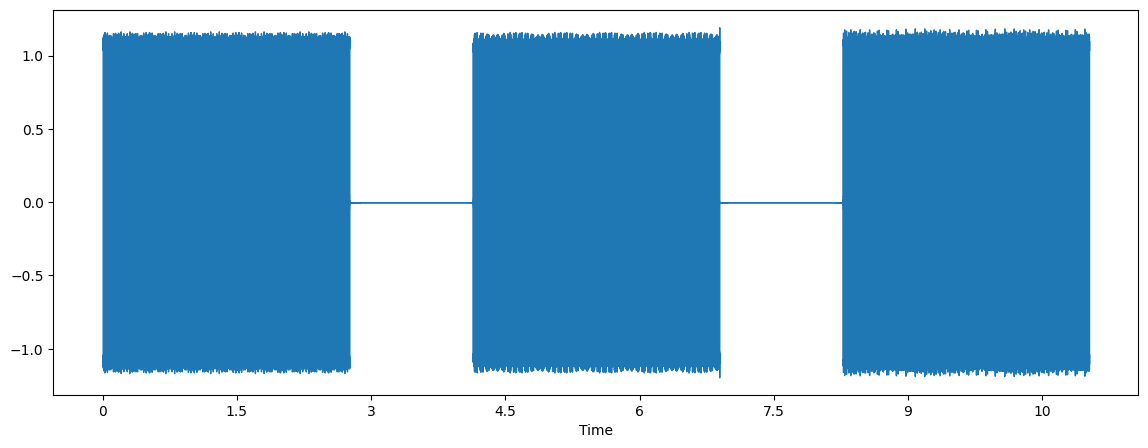

In [246]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

### 1 число

In [266]:
# YOUR CODE HERE

### 2 число

In [267]:
# YOUR CODE HERE

### 3 число

In [268]:
# YOUR CODE HERE

### Тест

In [269]:
# phone_number = [first: int, second: int, third: int]

In [ ]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   